In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_rows = 180

In [2]:
from tmtoolkit.utils import unpickle_file

models = unpickle_file('data/tm_final_results.pickle')
models

[({'eta': 0.7,
   'n_topics': 180,
   'alpha': 0.05555555555555555,
   'n_iter': 2000,
   'random_state': 20200918},
  {'model': <lda.lda.LDA at 0x7f40a072ea90>,
   'cao_juan_2009': 0.11512976617805985,
   'arun_2010': 240.13476983487237,
   'coherence_mimno_2011': -1.5269574077666448}),
 ({'eta': 0.9,
   'n_topics': 180,
   'alpha': 0.05555555555555555,
   'n_iter': 2000,
   'random_state': 20200918},
  {'model': <lda.lda.LDA at 0x7f40a07418e0>,
   'cao_juan_2009': 0.11787665410482431,
   'arun_2010': 251.6912567275862,
   'coherence_mimno_2011': -1.5321521355858605}),
 ({'eta': 0.7,
   'n_topics': 200,
   'alpha': 0.05,
   'n_iter': 2000,
   'random_state': 20200918},
  {'model': <lda.lda.LDA at 0x7f40a0747580>,
   'cao_juan_2009': 0.11403311473801361,
   'arun_2010': 232.2083384928255,
   'coherence_mimno_2011': -1.5198614066534426}),
 ({'eta': 0.9,
   'n_topics': 200,
   'alpha': 0.05,
   'n_iter': 2000,
   'random_state': 20200918},
  {'model': <lda.lda.LDA at 0x7f4059fa1490>,
   

In [3]:
ldamodel = models[0][1]['model']
ldamodel

In [4]:
from tmtoolkit.utils import pickle_data

pickle_data(ldamodel, 'data/tm_final_k180_eta0.7.pickle')

In [5]:
doc_topic = ldamodel.doc_topic_
topic_word = ldamodel.topic_word_

In [6]:
doc_labels, vocab, dtm = unpickle_file('data/dtm.pickle')
doc_labels = np.array(doc_labels)
vocab = np.array(vocab)
len(doc_labels), len(vocab), dtm.shape

(32921, 3278, (32921, 3278))

In [7]:
doc_labels[:10]

array(['007-drehorte-in-europa-klimavertraeglicher-james-bond-a-1295233',
       '070-shake-in-berlin-vertrauensuebung-mit-einer-emo-rapperin-a-7c4a0eb3-7c1b-474c-aaee-f2de6e165362',
       '1-fc-heidenheim-in-der-relegation-demoliert-in-die-groessten-spiele-der-vereinsgeschichte-a-383ce249-6865-4bfa-a8ea-2a89894ad7b2',
       '1-fc-heidenheim-unterliegt-werder-bremen-in-der-relegation-da-helfen-auch-keine-klatschpfannen-a-ea0861b0-dd7c-403a-99ab-38b6c25c7aed',
       '1-fc-kaiserslautern-beantragt-in-der-3-liga-insolvenz-pfaelzer-sauplan-a-69b7ee5a-5cc8-4f8c-9f67-c5f455a3ec9f',
       '1-fc-kaiserslautern-fussball-drittligist-stellt-antrag-auf-plan-insolvenz-a-fb530286-9b7b-4cd7-ae1f-9a876cc3f700',
       '1-fc-koeln-beendet-kooperation-mit-china-totaler-ueberwachungsstaat-a-1301960',
       '1-fc-koeln-holt-horst-heldt-und-markus-gisdol-neue-gesichter-alte-zweifel-a-1297292',
       '1-fc-koeln-kontert-kuendigung-eines-mitglieds-wegen-moschee-auf-dem-trikot-a-0fc58882-dffd-4f84-a157-

In [8]:
vocab[:10]

array(['10', '11', '20', 'ab', 'abbauen', 'abbrechen', 'abend', 'abends',
       'abgeben', 'abgeordnete'], dtype='<U27')

In [9]:
dtm

<32921x3278 sparse matrix of type '<class 'numpy.int32'>'
	with 4247828 stored elements in Compressed Sparse Row format>

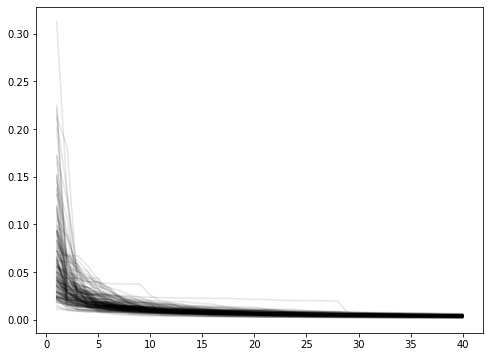

In [10]:
import matplotlib.pyplot as plt

topic_word_desc = -np.sort(-topic_word, axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
n_terms = 40
term_ranks = np.arange(1, n_terms+1)
for t in topic_word_desc:
    ax.plot(term_ranks, t[:n_terms], color = 'black', alpha=0.1)

fig;

In [11]:
highlight_topics = np.argsort(-topic_word_desc[:, [0, 8, 25]], axis=0)[0, :]
highlight_topics

array([131, 158,  93])

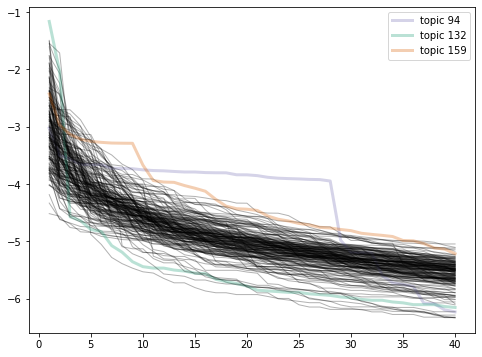

In [12]:
palette = plt.get_cmap('Dark2')

fig, ax = plt.subplots(figsize=(8, 6))
highlight_topics_handles = []
for i, t in enumerate(topic_word_desc):
    highlight_index = np.where(i == highlight_topics)[0]
    if len(highlight_index) > 0:
        color = palette(highlight_index[0])
        label = 'topic ' + str(i+1)
        lw = 3
    else:
        color = 'black'
        label = 'other topics'
        lw = 1
    
    hndl, = ax.plot(term_ranks, np.log(t[:n_terms]), color=color, label=label, lw=lw, alpha=0.3)
    
    if len(highlight_index) > 0:
        highlight_topics_handles.append(hndl)

ax.legend(handles=highlight_topics_handles, loc='best')
fig;

In [13]:
from tmtoolkit.topicmod.model_stats import topic_word_relevance
from tmtoolkit.bow.bow_stats import doc_lengths

doc_lengths = doc_lengths(dtm)

topic_word_rel = topic_word_relevance(topic_word, doc_topic, doc_lengths, lambda_=0.6)
topic_word_rel

array([[-6.56622682, -6.47633154, -6.48707646, ..., -6.72499435,
        -6.64484627, -5.20960509],
       [-7.43442808, -7.3445328 , -7.35527771, ..., -6.70589241,
        -5.11515226, -7.42773306],
       [-6.78071434, -6.69081905, -6.70156397, ..., -5.58955515,
        -5.97203059, -6.77401932],
       ...,
       [-7.14246662, -7.05257133, -7.06331625, ..., -7.30123414,
        -5.31684861, -7.1357716 ],
       [-3.15177778, -4.50491935, -3.50897469, ..., -7.03836263,
        -5.02925396, -6.09519551],
       [-7.59616309, -7.5062678 , -7.51701272, ..., -3.97399302,
        -6.00977477, -7.58946807]])

In [14]:
from tmtoolkit.topicmod.model_stats import filter_topics

covid19_topics = filter_topics(['corona*', 'covid*', 'pandemie', 'sars*', 'infektion', 'rki'],
                               vocab, topic_word_rel, match_type='glob', top_n=10)
covid19_topics  # these are topic *indices*

array([ 12,  27,  75,  89,  92, 107, 119, 125, 130, 154, 167, 179])

In [15]:
from tmtoolkit.topicmod.model_io import save_ldamodel_summary_to_excel

# this takes some time since the generated 

# save_ldamodel_summary_to_excel('output/tm_final_k180_eta0.7.xlsx',
#                                topic_word, doc_topic, doc_labels, vocab,
#                                dtm = dtm);
# save_ldamodel_summary_to_excel('output/tm_final_k180_eta0.7_tw_relevance.xlsx',
#                                topic_word_rel, doc_topic, doc_labels, vocab,
#                                dtm=dtm);

manually identified in `output/tm_final_k180_eta0.7_tw_relevance.xlsx`:

In [16]:
# substract 1 to get topic *indices* (these start at topic 0)

nonsensical_topics = np.array([7, 8, 46, 47, 61, 63, 64, 74, 78, 80,
                               93, 94, 97, 111, 113, 122, 124, 129,
                               139, 159, 170]) - 1
covid19_topics = np.array([13, 24, 28, 35, 50, 76, 90, 106, 108, 126,
                           131, 135, 152, 155, 168, 180]) - 1

In [17]:
from tmtoolkit.topicmod.model_stats import exclude_topics

doc_topic, topic_word, new_topic_mapping =  exclude_topics(
    nonsensical_topics, doc_topic, topic_word, return_new_topic_mapping=True
)
doc_topic.shape, topic_word.shape

((32921, 159), (159, 3278))

In [18]:
old_topic_ind, new_topic_ind = map(lambda x: np.array(list(x)),
                                   (new_topic_mapping.keys(), new_topic_mapping.values()))
covid19_topics = new_topic_ind[np.searchsorted(old_topic_ind, covid19_topics)]
covid19_topics

array([ 10,  21,  25,  32,  45,  67,  79,  92,  94, 108, 112, 116, 132,
       135, 147, 158])

In [19]:
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

topic_labels = generate_topic_labels_from_top_words(
    topic_word,
    doc_topic,
    doc_lengths,
    vocab,
    lambda_=0.6
)


In [20]:
topic_labels[covid19_topics]

array(['11_pandemie_coronakrise', '22_maske_maskenpflicht',
       '26_neuinfektionen_zahl', '33_spahn_test', '46_lockerungen_öffnen',
       '68_wuhan_coronavirus', '80_virus_sarscov2', '93_gates_foundation',
       '95_schließen_maßnahme', '109_coronakrise_kurzarbeit',
       '113_impfstoff_medikament', '117_hand_abstand', '133_arzt_patient',
       '136_zahl_todesfälle', '148_quarantäne_positiv',
       '159_coronakrise_corona'], dtype='<U33')

In [21]:
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib

marg_topic = marginal_topic_distrib(doc_topic, doc_lengths)
list(sorted(zip(topic_labels, marg_topic), key=lambda x: x[1], reverse=True))[:20]

[('26_neuinfektionen_zahl', 0.015712434406330807),
 ('75_minute_tor', 0.012762950363237005),
 ('108_trump_donald', 0.01272651858438072),
 ('105_prozent_quartal', 0.012365290954533646),
 ('80_virus_sarscov2', 0.012150155180471557),
 ('46_lockerungen_öffnen', 0.011952432146179335),
 ('95_schließen_maßnahme', 0.011331682833765531),
 ('158_bayer_dortmund', 0.01112611539262225),
 ('93_gates_foundation', 0.010949357258572412),
 ('119_leben_mensch', 0.010779585583945827),
 ('136_zahl_todesfälle', 0.010306918241285478),
 ('107_prozent_zahl', 0.010126169620470383),
 ('68_wuhan_coronavirus', 0.010071376604688579),
 ('159_coronakrise_corona', 0.010035174941218018),
 ('32_gericht_verurteilen', 0.009998688185347377),
 ('34_begriff_medium', 0.009733718116205612),
 ('11_pandemie_coronakrise', 0.00972157511571275),
 ('101_song_musik', 0.009688675866130446),
 ('87_modell_motor', 0.009622671837856773),
 ('66_politisch_demokratie', 0.009520435686119617)]

In [22]:
sum(marg_topic[covid19_topics])

0.1453778218044167

In [23]:
corpusmeta = unpickle_file('data/meta.pickle')

In [24]:
doc_dates = np.array([corpusmeta[d]['pub_date'] for d in doc_labels], dtype='datetime64')
doc_dates

array(['2019-11-13', '2020-01-28', '2020-06-29', ..., '2019-12-28',
       '2019-12-30', '2020-08-24'], dtype='datetime64[D]')

In [25]:
marg_covid19 = np.sum(doc_topic[:, covid19_topics], axis=1)
marg_covid19

array([0.0069487 , 0.01105691, 0.00979545, ..., 0.01371037, 0.04933051,
       0.488228  ])

In [26]:
docs_covid19 = pd.DataFrame({
    'label': doc_labels,
    'date': np.array([corpusmeta[d]['pub_date'] for d in doc_labels], dtype='datetime64'),
    'length': doc_lengths,
    'marginal_covid19': np.sum(doc_topic[:, covid19_topics], axis=1)
})
docs_covid19

,label,date,length,marginal_covid19
0,007-drehorte-in-europa-klimavertraeglicher-jam...,2019-11-13,310,0.006949
1,070-shake-in-berlin-vertrauensuebung-mit-einer...,2020-01-28,265,0.011057
2,1-fc-heidenheim-in-der-relegation-demoliert-in...,2020-06-29,226,0.009795
3,1-fc-heidenheim-unterliegt-werder-bremen-in-de...,2020-07-07,244,0.005234
4,1-fc-kaiserslautern-beantragt-in-der-3-liga-in...,2020-06-17,269,0.094734
...,...,...,...,...
32916,zwoelf-kinder-als-chefsache-a-d4533bfa-668c-49...,2020-04-11,421,0.129453
32917,zyklon-amphan-trifft-auf-indien-und-bangladesc...,2020-05-20,203,0.004783
32918,zypern-diebe-stehlen-koffer-mit-urne-darin-a-1...,2019-12-28,57,0.013710
32919,zypern-mutmassliche-urnendiebe-gefasst-familie...,2019-12-30,70,0.049331


In [27]:
docs_covid19.sort_values('marginal_covid19', ascending=False)

,label,date,length,marginal_covid19
8017,coronavirus-der-mund-nasen-schutz-ersetzt-nich...,2020-04-24,338,0.959562
8505,coronavirus-infizierte-genesene-tote-alle-live...,2020-03-18,394,0.946954
6949,corona-mundschutz-tragen-oder-nicht-tragen-a-e...,2020-04-02,391,0.934949
7130,corona-robert-koch-institut-meldet-hoechste-za...,2020-08-19,165,0.930488
32724,york-hovest-bildband-ueber-bedrohte-meere-und-...,2020-01-13,118,0.929479
...,...,...,...,...
2928,berlinale-2020-neuer-film-von-christian-petzol...,2020-02-23,794,0.001107
15348,grundrente-der-groko-wer-profitiert-und-wer-ni...,2019-11-12,817,0.001102
22974,niederlande-dsgvo-oma-muss-facebook-foto-ihres...,2020-05-22,881,0.001099
11708,eine-kuh-erklaert-die-welt-a-b4a34c61-2b89-447...,2020-02-25,855,0.001062


In [28]:
docs_covid19['weight'] = docs_covid19.groupby('date').length.transform(lambda g: g / g.sum())
docs_covid19

,label,date,length,marginal_covid19,weight
0,007-drehorte-in-europa-klimavertraeglicher-jam...,2019-11-13,310,0.006949,0.013959
1,070-shake-in-berlin-vertrauensuebung-mit-einer...,2020-01-28,265,0.011057,0.013212
2,1-fc-heidenheim-in-der-relegation-demoliert-in...,2020-06-29,226,0.009795,0.011430
3,1-fc-heidenheim-unterliegt-werder-bremen-in-de...,2020-07-07,244,0.005234,0.011631
4,1-fc-kaiserslautern-beantragt-in-der-3-liga-in...,2020-06-17,269,0.094734,0.011453
...,...,...,...,...,...
32916,zwoelf-kinder-als-chefsache-a-d4533bfa-668c-49...,2020-04-11,421,0.129453,0.021682
32917,zyklon-amphan-trifft-auf-indien-und-bangladesc...,2020-05-20,203,0.004783,0.008875
32918,zypern-diebe-stehlen-koffer-mit-urne-darin-a-1...,2019-12-28,57,0.013710,0.004819
32919,zypern-mutmassliche-urnendiebe-gefasst-familie...,2019-12-30,70,0.049331,0.004296


In [29]:
np.allclose(docs_covid19.groupby('date').weight.sum(), 1.0)

True

In [30]:
ts_covid19topics = docs_covid19.groupby('date').apply(lambda g: (g.weight * g.marginal_covid19).sum())
ts_covid19topics

date
2019-10-01    0.045869
2019-10-02    0.058730
2019-10-03    0.053224
2019-10-04    0.032393
2019-10-05    0.028396
                ...   
2020-08-26    0.162066
2020-08-27    0.160073
2020-08-28    0.119419
2020-08-29    0.124897
2020-08-30    0.087180
Length: 335, dtype: float64

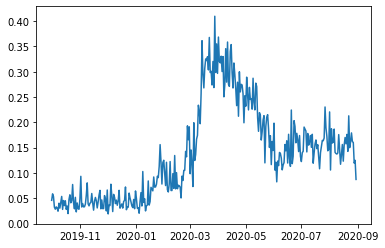

In [31]:
fig, ax = plt.subplots()

ax.plot(ts_covid19topics.index, ts_covid19topics)
fig;

In [32]:
coviddatahub_full = pd.read_csv('data/covid19datahub-2020-11-19.csv')
coviddatahub_full['date'] = pd.to_datetime(coviddatahub_full.date)
coviddatahub_full

,id,date,tests,confirmed,recovered,deaths,hosp,vent,icu,population,...,currency,administrative_area_level,administrative_area_level_1,administrative_area_level_2,administrative_area_level_3,latitude,longitude,key,key_apple_mobility,key_google_mobility
0,AFG,2020-01-01,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
1,AFG,2020-01-02,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
2,AFG,2020-01-03,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
3,AFG,2020-01-04,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
4,AFG,2020-01-05,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64471,ZWE,2020-11-15,153248,8829,8096,257,0,0,0,14439018,...,ZWD,1,Zimbabwe,NaN,NaN,-20.0,30.0,NaN,NaN,ZW
64472,ZWE,2020-11-16,153248,8897,8116,257,0,0,0,14439018,...,ZWD,1,Zimbabwe,NaN,NaN,-20.0,30.0,NaN,NaN,ZW
64473,ZWE,2020-11-17,153248,8945,8164,260,0,0,0,14439018,...,ZWD,1,Zimbabwe,NaN,NaN,-20.0,30.0,NaN,NaN,ZW
64474,ZWE,2020-11-18,153248,8981,8184,261,0,0,0,14439018,...,ZWD,1,Zimbabwe,NaN,NaN,-20.0,30.0,NaN,NaN,ZW


In [33]:
coviddatahub = coviddatahub_full.loc[
    (coviddatahub_full.date >= '2020-01-01') & (coviddatahub_full.date <= docs_covid19.date.max()),
    ['id', 'date', 'confirmed', 'administrative_area_level_1']
]

In [34]:
coviddatahub['daily'] = coviddatahub.groupby('id').confirmed.diff().fillna(0).astype(np.int)
coviddatahub

,id,date,confirmed,administrative_area_level_1,daily
0,AFG,2020-01-01,0,Afghanistan,0
1,AFG,2020-01-02,0,Afghanistan,0
2,AFG,2020-01-03,0,Afghanistan,0
3,AFG,2020-01-04,0,Afghanistan,0
4,AFG,2020-01-05,0,Afghanistan,0
...,...,...,...,...,...
64390,ZWE,2020-08-26,6251,Zimbabwe,55
64391,ZWE,2020-08-27,6292,Zimbabwe,41
64392,ZWE,2020-08-28,6388,Zimbabwe,96
64393,ZWE,2020-08-29,6406,Zimbabwe,18


In [35]:
coviddata_de = coviddatahub.loc[coviddatahub.id == 'DEU', :]

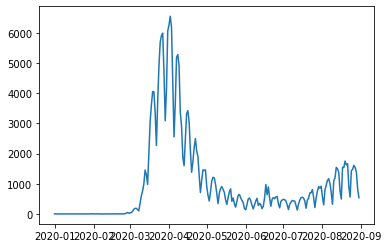

In [36]:
fig, ax = plt.subplots()

ax.plot(coviddata_de.date, coviddata_de.daily)
fig;

In [37]:
coviddata_world = coviddatahub.groupby('date').daily.sum()

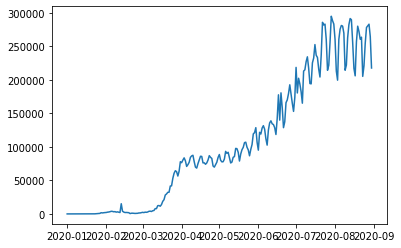

In [38]:
fig, ax = plt.subplots()

ax.plot(coviddata_world.index, coviddata_world)
fig;

In [39]:
ts_covid19topics2020 = ts_covid19topics[ts_covid19topics.index >= '2020-01-01']

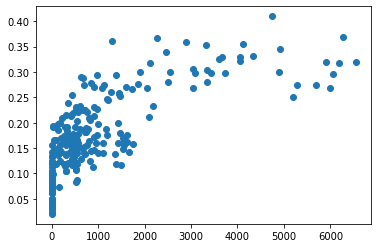

In [40]:
fig, ax = plt.subplots()

ax.scatter(coviddata_de.daily, ts_covid19topics2020)
fig;

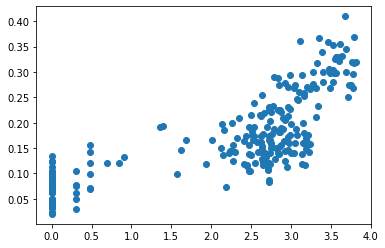

In [45]:
fig, ax = plt.subplots()

ax.scatter(np.log10(1 + coviddata_de.daily), ts_covid19topics2020)
fig;

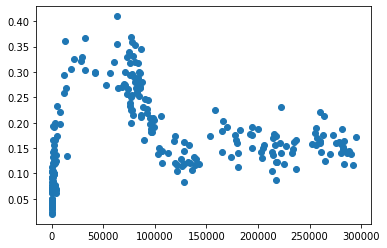

In [41]:
fig, ax = plt.subplots()

ax.scatter(coviddata_world, ts_covid19topics2020)
fig;

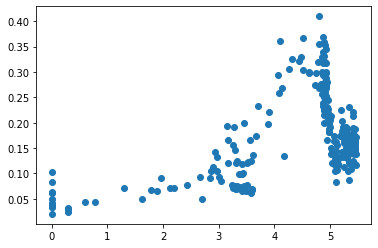

In [46]:
fig, ax = plt.subplots()

ax.scatter(np.log10(1 + coviddata_world), ts_covid19topics2020)
fig;